In [ ]:
%load_ext autoreload
%autoreload 2

from IPython.display import display

from typing import List
from chess import Board
from chess.pgn import Game
from data_loading import board_to_tensor, load_games

import matplotlib.pyplot as plt
import seaborn as sns

## Data loading

The data used for training has been acquired from [https://database.nikonoel.fr/](https://database.nikonoel.fr/). It contains millions of games of high-rated players (lichess ELO >= 2500). The chunk below is only from May 2023.

In [ ]:
games = load_games('lichess_elite_2023-05.pgn')

In [3]:
games: List[Game] = games

## Data analysis

In [4]:
# Amount of games loaded
len(games)

312993

#### Types of games

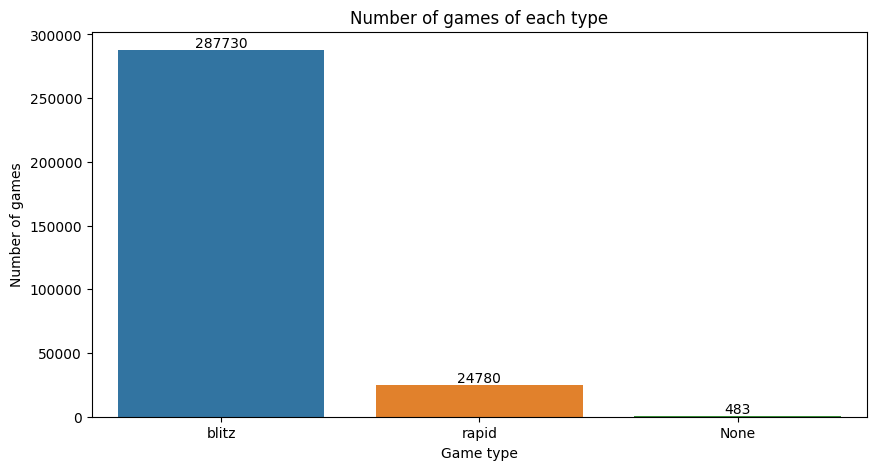

{'blitz': 287730, 'rapid': 24780, None: 483}

In [5]:
def analyze_games_per_header(games: List[Game], header: str, ylabel: str, xlabel: str, title: str, chart_type='bar'):
    game_types = set()

    for game in games:
        game_types.add(game.headers.get(header))

    game_types_map = {game_type: 0 for game_type in game_types}

    for game in games:
        game_types_map[game.headers.get(header)] += 1

    sorted_game_types_map = dict(sorted(game_types_map.items(), key=lambda item: item[1], reverse=True))

    plt.figure(figsize=(10, 5))

    if chart_type == 'bar':
        sns.barplot(x=[str(k) for k in sorted_game_types_map.keys()], y=list(sorted_game_types_map.values()))
        plt.ylabel(ylabel)
        plt.xlabel(xlabel)
        plt.title(title)

        for index, value in enumerate(sorted_game_types_map.values()):
            plt.text(index, value, str(value), ha='center', va='bottom')

    elif chart_type == 'pie':
        plt.pie(sorted_game_types_map.values(), labels=sorted_game_types_map.keys(), autopct='%1.1f%%')
        plt.title(title)

    plt.show()

    return sorted_game_types_map

analyze_games_per_header(games, 'EventType', 'Number of games', 'Game type', 'Number of games of each type')

We can see that most of the games are blitz (short time format, usually between 3 and 8 minutes per side, with or without increments). This is not ideal, since players spend significantly way less time thinking on blitz games, compared to rapid (usually 10 to 15 minutes per side, with increments), therefore we could say the moves are less precise.

However, it is a known fact that high-rated players on lichess.org prefer playing blitz, and play longer time formats signficantly less. Because of that, rapid and classical foramts on lichess.org tend to have "inflated" player ratings, e.g. 2500 in classical on lichess is nowhere near 2500 in the real life - it is less. There aren't statistics on this, but probably the smallest difference between lichess Elo and real-life (e.g. FIDE Elo) is in blitz games, as they are the most played on lichess.

It is good that the dataset doesn't contain bullet games (very short time format - 1 to 2 minutes per side), since the thinking time in bullet is usually less than a second per move, which significantly reduces the quality of the games. The practice of "dirty flagging", which is purposefully making fast poor-quality moves, in order to cause your opponent to lose time and thus lose the game, is also very common in bullet games.

There are very few games without a type - these are not important.

To gain more insight, we can also analyze the `Event` header.

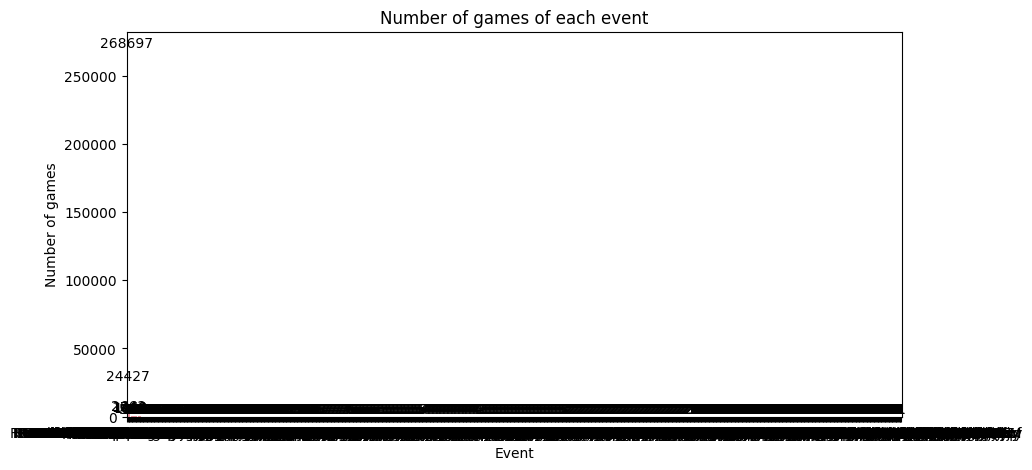

{'Rated Blitz game': 268697,
 'Rated Rapid game': 24427,
 'Rated Blitz tournament may23bta': 2662,
 'Rated Blitz tournament kazakh02': 1746,
 'Rated Blitz tournament kazakh03': 1460,
 'Rated Blitz tournament kazakh01': 1020,
 'Rated Blitz tournament zajHUySm': 558,
 'Rated Classical game': 476,
 'Rated Blitz tournament 8z4iBper': 460,
 'Rated Blitz tournament vukKLRyk': 453,
 'Rated Blitz tournament jWmPAG5T': 363,
 'Rated Blitz tournament W55y3bul': 347,
 'Rated Blitz tournament BWJ1NxCE': 323,
 'Rated Blitz tournament grn188HU': 304,
 'Rated Blitz tournament 5xWVdDf0': 294,
 'Rated Blitz tournament jJrhKYfK': 253,
 'Rated Blitz tournament 8VuOwzuu': 252,
 'Rated Blitz tournament ZjFemrn4': 241,
 'Rated Blitz tournament H0CJLCgy': 182,
 'Rated Blitz tournament may23str': 173,
 'Rated Blitz tournament kIcocN07': 131,
 'Rated Blitz tournament 2iLibD8E': 129,
 'Rated Blitz tournament 4HRLtIAq': 116,
 'Rated Blitz tournament GzcIpi2S': 114,
 'Rated Blitz tournament gOZGirjX': 111,
 'Rated

In [6]:
analyze_games_per_header(games, 'Event', 'Number of games', 'Event', 'Number of games of each event')

It appears that the `Event` header contains the unique IDs of tournaments (see output above). This makes the barchart useless, but it's an interesting thing to learn about the dataset.

#### Game outcomes

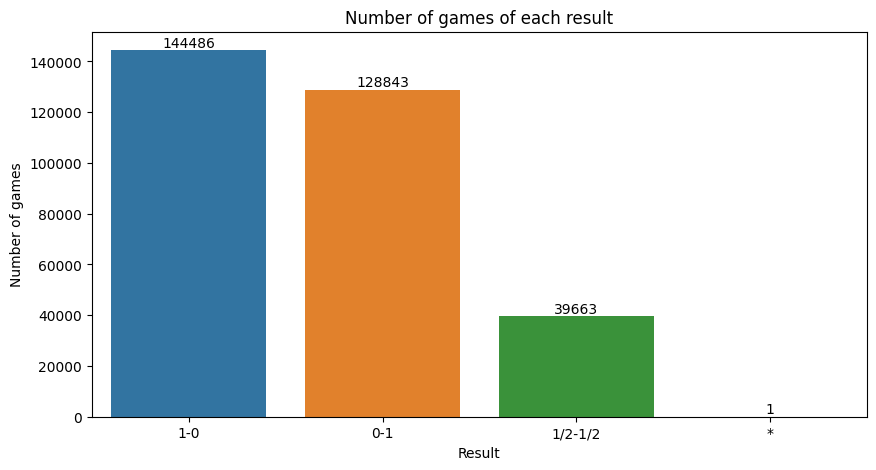

{'1-0': 144486, '0-1': 128843, '1/2-1/2': 39663, '*': 1}

In [7]:
analyze_games_per_header(games, 'Result', 'Number of games', 'Result', 'Number of games of each result')

Here is some explanation of the results:

- **1-0** means **white** won the game
- **0-1** means **black** won the game
- **1/2-1/2** means the game ended in a draw
- **\*** means "other", such as the the game is still ongoing.

It is a known fact that in chess white has a slight advantage over black due to the first move advantage. According to [Wikipedia](https://en.wikipedia.org/wiki/First-move_advantage_in_chess#Winning_percentages), the advantage for white is between 52% and 56%. We can plot our dataset on a pie chart to see how that compares to the Wikipedia statistics.

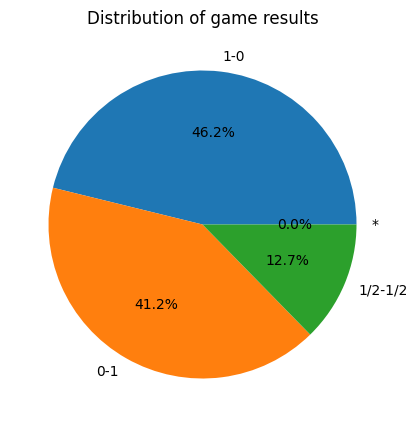

In [8]:
map = analyze_games_per_header(games, 'Result', None, None, 'Distribution of game results', 'pie')

By adding half of the draw percentage to white's win percentage, we can see what the advantage is for white in our dataset:

In [9]:
print("White's advantage: ", (map['1-0'] / len(games)) + (map['1/2-1/2'] / len(games) / 2))

White's advantage:  0.5249877792794089


#### Players rating

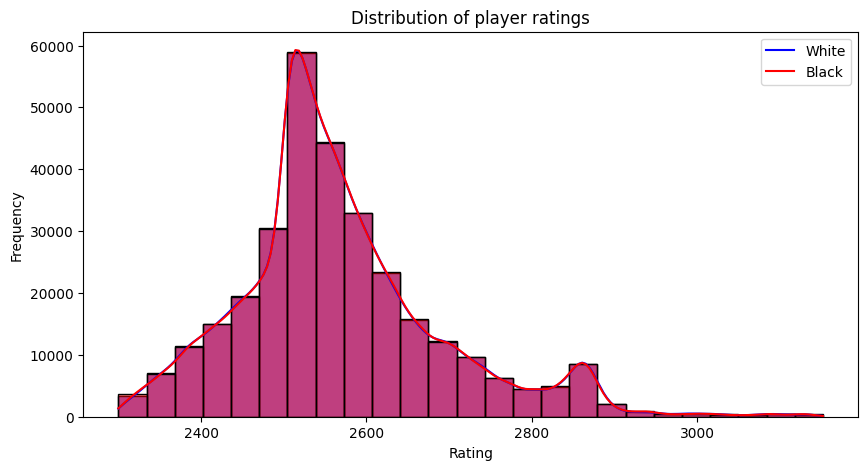

In [10]:
white_ratings = []
black_ratings = []

for game in games:
    white_ratings.append(int(game.headers.get('WhiteElo') or 2500))
    black_ratings.append(int(game.headers.get('BlackElo') or 2500))

plt.figure(figsize=(10, 5))
sns.histplot(white_ratings, color='blue', bins=25, kde=True)
sns.histplot(black_ratings, color='red', bins=25, kde=True)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of player ratings')
plt.legend(['White', 'Black'])
plt.show()


Both sides have basically the same distribution of ratings, and this is totally understandable and expected. What we can also observe here is the "rating inflation" which exists in lichess.org in comparison to FIDE chess. Currently, in professional chess there aren't any players rated above 3000, whereas in lichess.org, there are quite a few.

#### Moves per game

In [15]:
# check if PlyCount is missing in some games
none_plycount = 0
for game in games:
    if game.headers.get('PlyCount') is None:
        none_plycount += 1

print('Games without PlyCount: ', none_plycount)

Games without PlyCount:  2


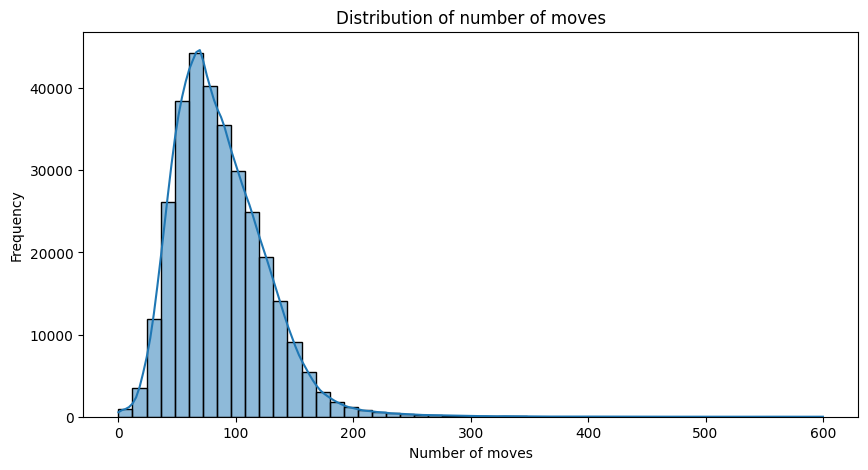

Average number of moves:  86.6249852233117
Number of games with moves < 20:  2555


In [19]:
# analyze the moves number distribution

moves_number = []

for game in games:
    moves_number.append(int(game.headers.get('PlyCount') or 0))

plt.figure(figsize=(10, 5))
sns.histplot(moves_number, bins=50, kde=True)
plt.xlabel('Number of moves')
plt.ylabel('Frequency')
plt.title('Distribution of number of moves')
plt.show()

print('Average number of moves: ', sum(moves_number) / len(moves_number))
print('Number of games with moves < 20: ', len([x for x in moves_number if x < 20]))


#### Openings

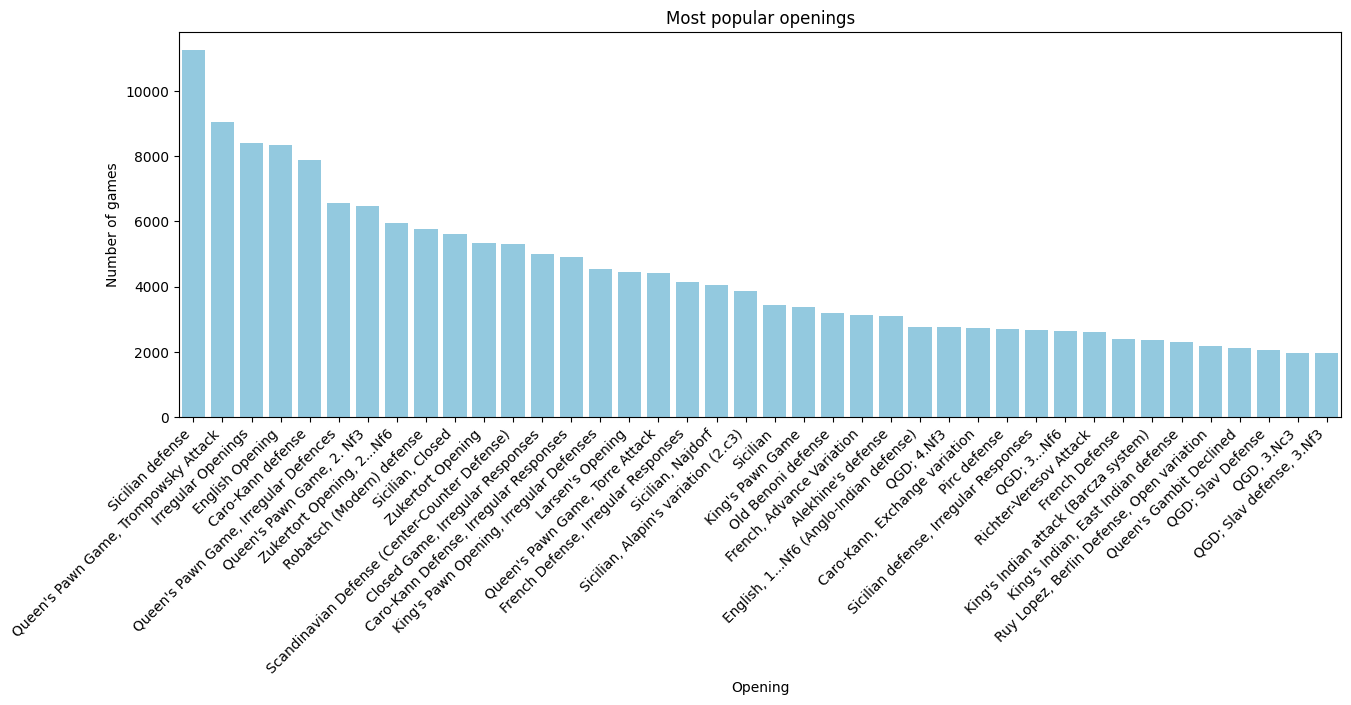

In [43]:
import pandas as pd

openings = {}
eco_codes = pd.read_csv('eco_map.csv')
eco_codes = eco_codes.set_index('code').to_dict(orient='index')

for game in games:
    eco_entry = eco_codes.get(game.headers.get('ECO'))
    if eco_entry:
        opening = eco_entry['name']
    else:
        opening = 'Unknown'
    openings[opening] = openings.get(opening, 0) + 1

sorted_openings = dict(sorted(openings.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(15, 5))
sns.barplot(x=[str(k) for k in list(sorted_openings.keys())[:40]], y=list(sorted_openings.values())[:40], color='skyblue')
plt.ylabel('Number of games')
plt.xlabel('Opening')
plt.title('Most popular openings')
plt.xticks(rotation=45, ha='right')
plt.show()